# Building an aircraft image classifier with *fast.ai* / *PyTorch*

The purpose of this notebook is to create a computer vision model that, given a picture, predicts if it is an image of an airliner, a fighter jet or an attack helicopter.

### 1) Create the dataset 

In [2]:
# Import fastai module for computer vision
from fastai.vision.all import *
from fastai.vision.widgets import *

We have to redefine fastai's function for using Azure's Bing Image Search API. It does not work anymore because of changes recently made to the Bing API. See https://forums.fast.ai/t/02-production-permissiondenied-error/65823/28 or https://forums.fast.ai/t/getting-the-bing-image-search-key/67417/70

In [2]:
# Define the function to retrieve pictures from Bing 
def search_images_bing(key, term, max_images: int = 1000, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])
    
# Key required to use Azure's image search API
key = "###"

In [8]:
# Let us do a query to see if everything works fine
results = search_images_bing(key, 'Strandberg guitar', min_sz=128)
ims = results.attrgot('contentUrl')
len(ims)

150

It seems that we just received 150 URLs of Standberg guitar pictures.

In [9]:
# Get the first URL
ims[0]

'http://media.guitarcenter.com/is/image/MMGS7/Boden-Original-6-Electric-Guitar-Red/J52621000003000-00-500x500.jpg'

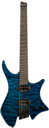

In [10]:
# Download and display a given picture, say the 13th of the list
dest = 'images/strandberg_guitar.jpg'
download_url(ims[12], dest)
Image.open(dest).to_thumb(128,128)

We are ready to collect the pictures we will use to train our model with. The goal of the classifier is to distinguish between an *airliner*, a *fighter jet* and an *attack helicopter*. Do not ask me why I chose this problem: one thing led to another and here I am :) We could query these exact words (*airliner* / *fighter jet*/*attack helicopter*) but it appears that searching for specific models works better and returns less irrelevant pictures.

In [40]:
# List the keywords to be queried and define a folder to retrieve the matching pictures
flying_types = 'mirage 2000','apache helicopter','airbus a380'
path = Path('flying_things')

In [41]:
# Collect and store the pictures, if not already done
if not path.exists():
    path.mkdir()
    for o in flying_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'flying thing: {o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [42]:
# Check if the query went OK
fns = get_image_files(path)
fns

(#446) [Path('flying_things/mirage 2000/00000000.jpg'),Path('flying_things/mirage 2000/00000006.jpg'),Path('flying_things/mirage 2000/00000001.jpg'),Path('flying_things/mirage 2000/00000004.jpg'),Path('flying_things/mirage 2000/00000003.jpg'),Path('flying_things/mirage 2000/00000002.jpg'),Path('flying_things/mirage 2000/00000009.jpg'),Path('flying_things/mirage 2000/00000008.jpg'),Path('flying_things/mirage 2000/00000005.png'),Path('flying_things/mirage 2000/00000011.jpg')...]

In [43]:
# Check if some files are corrupted
failed = verify_images(fns)
failed

(#4) [Path('flying_things/mirage 2000/00000003.jpg'),Path('flying_things/apache helicopter/00000017.png'),Path('flying_things/apache helicopter/00000096.jpg'),Path('flying_things/airbus a380/00000129.jpg')]

In [44]:
# Remove invalid pictures
failed.map(Path.unlink);

In [3]:
# Define rules to create the dataset
flying_things = DataBlock(
    # Specify independent / dependent variables
    blocks=(ImageBlock, CategoryBlock),
    # get_image_files() recursively retrieves images from a given path
    get_items=get_image_files,
    # Split the dataset into train/validation subsets
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # The label of a given picture is the name of its containing folder
    get_y=parent_label,
    # Resize pics to 224px*224px, and randomly crop them to half their original size
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    # Apply standard data augmentation techniques:
    # rotation, flipping, perspective warping, contrast/brightness changes...
    batch_tfms=aug_transforms())

In [46]:
# Now, create the dataset using all the pictures retrieved above
dls = flying_things.dataloaders(path)

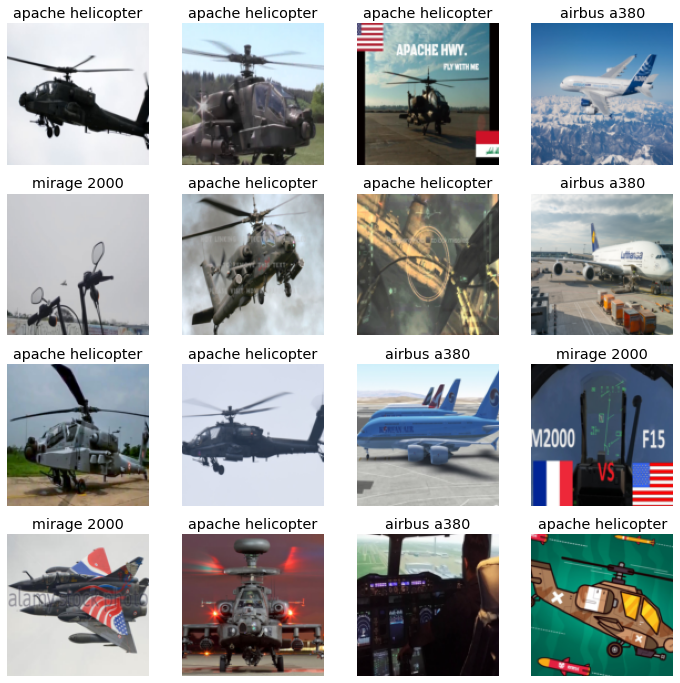

In [47]:
# Display 16 pictures from the validation set
dls.valid.show_batch(max_n=16, nrows=4)

We can already see that a few images are irrelevant : pictures taken from inside the cockpit, cartoons, video games, aircrafts far away, etc...

### 2) Train the model

In the cell below, we load the pre-trained 18-layer convolutional neural network [ResNet](https://arxiv.org/pdf/1512.03385.pdf) available in the torchvision library from PyTorch. It has already been fed 1.3 million images. We adapt it for our specific problem using our dataset.

In [98]:
dls = flying_things.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.825741,0.686523,0.246154,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.610587,0.234752,0.061538,00:06
1,0.485592,0.145786,0.076923,00:06
2,0.372040,0.129032,0.076923,00:06
3,0.289963,0.126122,0.061538,00:05


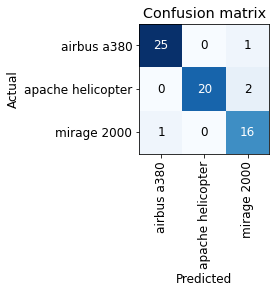

In [99]:
# Build the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

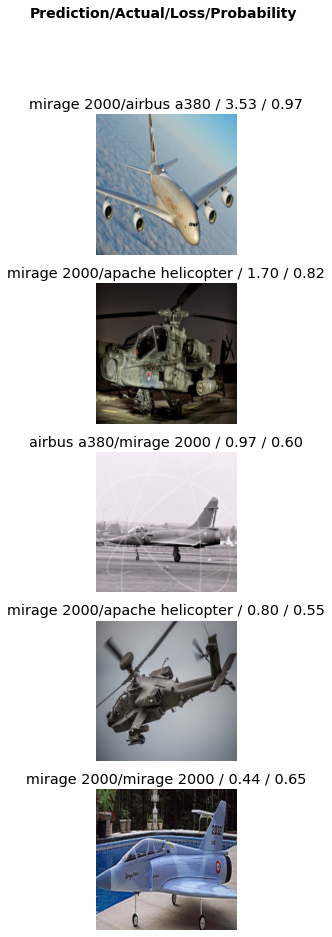

In [100]:
# Plot the pictures with highest losses
interp.plot_top_losses(5, nrows=5)

### 3) Clean the data

In order to clean the dataset, let us take advantage of the incredibly useful feature from *fast.ai* called `ImageClassifierCleaner()`. It shows the pictures with the worst losses, and lets the user either erase them or change their label if it is wrong. More precisely, it returns the indices of the said images.

In [94]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [97]:
# Use the indices returned by `ImageClassifierCleaner()` to do the actual cleaning.
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Now, the model can be trained again using the purged dataset. This process is repeated until the accuracy and the confusion matrix are satisfactory.

### 4) Deploy the model into production

In [101]:
# Save the model
learn.export()

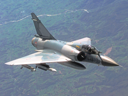

In [3]:
# Use the model for prediction with new pictures
Image.open('images/mirage_2000.jpg').to_thumb(128,128)

The `Learner.predict()` function generates the predicted category and probabilities associated with each category.

In [104]:
learn.predict('images/mirage_2000.jpg')

('mirage 2000',
 TensorImage(2),
 TensorImage([4.6920e-05, 2.1769e-07, 9.9995e-01]))

The order of the labels can be retrieved if needed:

In [105]:
learn.dls.vocab

['airbus a380', 'apache helicopter', 'mirage 2000']

The aircraft classifier is deployed on the cloud application platform Heroku at https://aircraft-classifier-007.herokuapp.com/. The source of the app is available on [GitHub](https://github.com/datatrigger/aircraft_classifier).